## 📋 Notebook Overview

This notebook mirrors the previous Titanic workflow but uses the **UCI Adult / Census Income** dataset.

### What you will find here:
1. **Custom MI Implementation** leveraging `helper_functions.py`
2. **Custom HSIC Implementation** for non-linear dependence
3. **Feature Engineering Pipeline** tailored for census attributes
4. **Model Comparisons**: baseline vs engineered vs transformed features
5. **SHAP Validation** confirming MI/HSIC selections

### Key Questions:
- Which socioeconomic attributes best explain income > 50K?
- How do MI and HSIC rankings compare on this high-dimensional dataset?
- Do engineered interactions boost performance, or introduce noise?
- How well do MI/HSIC selections agree with SHAP explanations?

## 📚 Import Libraries

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

# Custom Functions
from helper_functions import (
    mutual_information_from_scratch,
    hsic_from_scratch,
    OptimalMIEstimator
)

# Configuration
set_config(transform_output="pandas")
np.random.seed(42)
sns.set_style('whitegrid')

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


## 📊 Load Census Data

In [2]:
# Download Adult dataset from UCI repository
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]
train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

df_train_raw = pd.read_csv(train_url, names=column_names, na_values='?', skipinitialspace=True)
df_test_raw = pd.read_csv(test_url, names=column_names, na_values='?', skipinitialspace=True, skiprows=1)
df = pd.concat([df_train_raw, df_test_raw], ignore_index=True)
df['income'] = df['income'].str.strip().str.replace('.', '', regex=False)
df = df.dropna().reset_index(drop=True)

df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df['income'])

print(f'📊 Dataset loaded: {len(df)} samples after cleaning')
print(f'   Training: {len(df_train)} | Validation: {len(df_val)}')
print(f'   Class balance (income>50K): {df["income"].value_counts(normalize=True).get(">50K", 0):.1%}')
df.head()

📊 Dataset loaded: 45222 samples after cleaning
   Training: 36177 | Validation: 9045
   Class balance (income>50K): 24.8%


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 🛠️ Feature Engineering Pipeline
Creating socioeconomic interactions tailored for the Adult dataset.

In [3]:
class AdultCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X.columns = [c.strip().lower().replace(' ', '_') for c in X.columns]
        return X

class CapitalFeatureCreator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['capital_gain_log'] = np.log1p(X['capital-gain'])
        X['capital_loss_log'] = np.log1p(X['capital-loss'])
        X['capital_net'] = X['capital-gain'] - X['capital-loss']
        X['has_capital_gain'] = (X['capital-gain'] > 0).astype(int)
        X['has_capital_loss'] = (X['capital-loss'] > 0).astype(int)
        return X

class DemographicFeatureCreator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['age_bucket'] = pd.cut(
            X['age'], bins=[16, 25, 35, 45, 55, 65, 90],
            labels=['18-25','26-35','36-45','46-55','56-65','66+'], include_lowest=True
        ).astype(str)
        X['hours_bucket'] = pd.cut(
            X['hours-per-week'], bins=[0, 30, 40, 50, 60, 100],
            labels=['<30','30-40','41-50','51-60','60+'], include_lowest=True
        ).astype(str)
        X['is_overtime'] = (X['hours-per-week'] > 45).astype(int)
        X['is_foreign'] = (X['native-country'] != 'United-States').astype(int)
        return X

class HouseholdFeatureCreator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        household_map = {
            'Husband': 'married',
            'Wife': 'married',
            'Own-child': 'family',
            'Not-in-family': 'single',
            'Unmarried': 'single',
            'Other-relative': 'family'
        }
        X['relationship_grouped'] = X['relationship'].map(household_map).fillna('other')
        X['is_single'] = (X['relationship_grouped'] == 'single').astype(int)
        X['is_married'] = (X['relationship_grouped'] == 'married').astype(int)
        return X

class CategoryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, exclude_cols=None):
        self.exclude_cols = exclude_cols or []
        self.category_maps = {}
    def fit(self, X, y=None):
        categorical_cols = X.select_dtypes(include='object').columns
        for col in categorical_cols:
            if col in self.exclude_cols:
                continue
            categories = X[col].astype('category').cat.categories
            self.category_maps[col] = {cat: idx for idx, cat in enumerate(categories)}
        return self
    def transform(self, X):
        X = X.copy()
        for col, mapping in self.category_maps.items():
            X[col] = X[col].map(mapping).fillna(-1).astype(int)
        return X

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop):
        self.cols_to_drop = cols_to_drop
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(columns=self.cols_to_drop, errors='ignore')

print('✅ Transformer classes defined!')

✅ Transformer classes defined!


In [4]:
pipeline = Pipeline(steps=[
    ('cleaner', AdultCleaner()),
    ('capital', CapitalFeatureCreator()),
    ('demographic', DemographicFeatureCreator()),
    ('household', HouseholdFeatureCreator()),
    ('dropper', ColumnDropper(cols_to_drop=['fnlwgt', 'education'])),
    ('encoder', CategoryEncoder(exclude_cols=['income']))
])

df_eng_train = pipeline.fit_transform(df_train)
df_eng_val = pipeline.transform(df_val)

print('✅ Feature engineering complete!')
print(f'   Original columns: {len(df.columns)}')
print(f'   Engineered columns: {len(df_eng_train.columns)}')
feature_list = [col for col in df_eng_train.columns if col != 'income']
print(f'Engineered feature sample ({len(feature_list)} total): {feature_list[:15]} ...')

✅ Feature engineering complete!
   Original columns: 15
   Engineered columns: 25
Engineered feature sample (24 total): ['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'capital_gain_log', 'capital_loss_log', 'capital_net'] ...


c:\Users\arthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


## 🔬 Part 1: Mutual Information Analysis

In [5]:
X_eng = df_eng_train.drop('income', axis=1)
y_eng = (df_eng_train['income'] == '>50K').astype(int)

print(f'📊 Analyzing {len(X_eng.columns)} engineered features')
for idx, col in enumerate(X_eng.columns[:15], 1):
    print(f'   {idx}. {col}')
if len(X_eng.columns) > 15:
    print('   ...')

📊 Analyzing 24 engineered features
   1. age
   2. workclass
   3. education-num
   4. marital-status
   5. occupation
   6. relationship
   7. race
   8. sex
   9. capital-gain
   10. capital-loss
   11. hours-per-week
   12. native-country
   13. capital_gain_log
   14. capital_loss_log
   15. capital_net
   ...


### 🔍 Compute MI Scores with Auto Binning

In [6]:
mi_results = []
binning_methods = ['scott', 'knuth', 'fd', 'sturges', 'sqrt', 'auto']

print('🔄 Computing MI scores for Adult features...')

for feature in X_eng.columns:
    feature_data = X_eng[feature].values.astype(float)
    target_data = y_eng.values.astype(float)
    mask = ~(np.isnan(feature_data) | np.isnan(target_data))
    feature_clean = feature_data[mask]
    target_clean = target_data[mask]
    feature_results = {'feature': feature}
    for method in binning_methods:
        try:
            estimator = OptimalMIEstimator(method=method)
            mi_score, bins, selected_method = estimator.estimate(feature_clean, target_clean)
            feature_results[f'{method}_mi'] = mi_score
            feature_results[f'{method}_bins'] = bins
            feature_results[f'{method}_method'] = selected_method
        except Exception as e:
            feature_results[f'{method}_mi'] = np.nan
            feature_results[f'{method}_bins'] = np.nan
    mi_results.append(feature_results)

mi_df = pd.DataFrame(mi_results)
print('✅ MI computation finished!')

c:\Users\arthu\Documents\Estudos\UFSC\MATERIAS_POS\AlgoritmosDados\FeatureEngineering\helper_functions.py:167: RuntimeWarning: divide by zero encountered in scalar divide
  bins = int((np.max(x) - np.min(x)) / bin_width)
c:\Users\arthu\Documents\Estudos\UFSC\MATERIAS_POS\AlgoritmosDados\FeatureEngineering\helper_functions.py:167: RuntimeWarning: divide by zero encountered in scalar divide
  bins = int((np.max(x) - np.min(x)) / bin_width)


🔄 Computing MI scores for Adult features...


c:\Users\arthu\Documents\Estudos\UFSC\MATERIAS_POS\AlgoritmosDados\FeatureEngineering\helper_functions.py:167: RuntimeWarning: divide by zero encountered in scalar divide
  bins = int((np.max(x) - np.min(x)) / bin_width)
c:\Users\arthu\Documents\Estudos\UFSC\MATERIAS_POS\AlgoritmosDados\FeatureEngineering\helper_functions.py:167: RuntimeWarning: divide by zero encountered in scalar divide
  bins = int((np.max(x) - np.min(x)) / bin_width)
c:\Users\arthu\Documents\Estudos\UFSC\MATERIAS_POS\AlgoritmosDados\FeatureEngineering\helper_functions.py:167: RuntimeWarning: divide by zero encountered in scalar divide
  bins = int((np.max(x) - np.min(x)) / bin_width)
c:\Users\arthu\Documents\Estudos\UFSC\MATERIAS_POS\AlgoritmosDados\FeatureEngineering\helper_functions.py:167: RuntimeWarning: divide by zero encountered in scalar divide
  bins = int((np.max(x) - np.min(x)) / bin_width)
c:\Users\arthu\Documents\Estudos\UFSC\MATERIAS_POS\AlgoritmosDados\FeatureEngineering\helper_functions.py:167: Runti

✅ MI computation finished!


### 📊 Visualize MI Scores

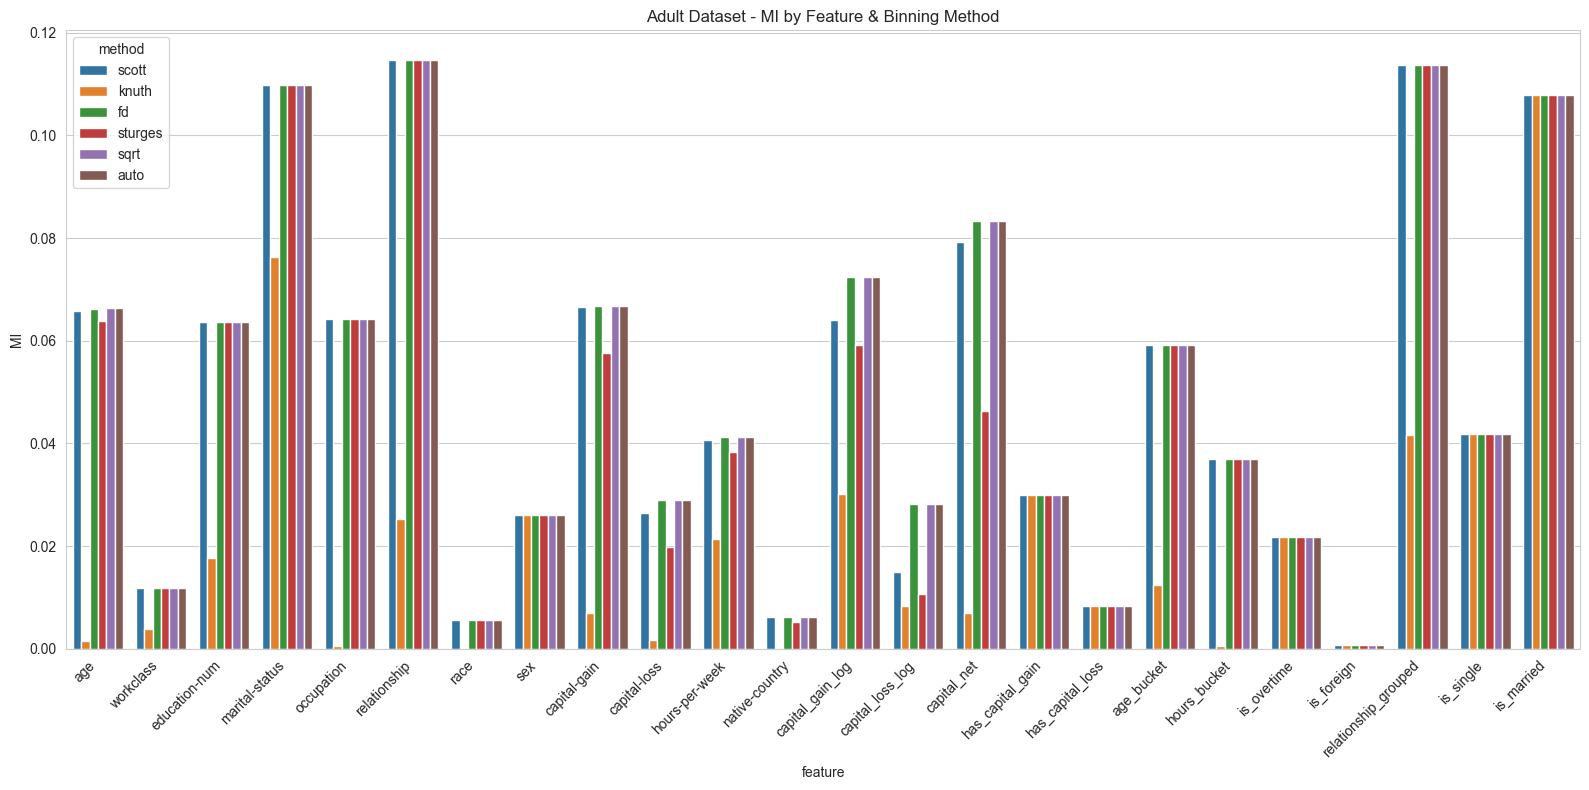

In [7]:
mi_cols = [col for col in mi_df.columns if col.endswith('_mi')]
mi_plot = mi_df[['feature'] + mi_cols].copy()
mi_plot.columns = ['feature'] + [col.replace('_mi', '') for col in mi_cols]
mi_melted = mi_plot.melt(id_vars='feature', var_name='method', value_name='MI')

plt.figure(figsize=(16, 8))
sns.barplot(data=mi_melted, x='feature', y='MI', hue='method')
plt.xticks(rotation=45, ha='right')
plt.title('Adult Dataset - MI by Feature & Binning Method')
plt.tight_layout()
plt.show()

### 🏆 MI Ranking (Auto)

In [8]:
mi_ranked = mi_df[['feature', 'auto_mi', 'auto_bins', 'auto_method']].copy()
mi_ranked = mi_ranked.sort_values('auto_mi', ascending=False).reset_index(drop=True)
mi_ranked['rank'] = mi_ranked.index + 1

print('🏅 Top 10 Features by Mutual Information (Auto)')
for _, row in mi_ranked.head(10).iterrows():
    print(f'   {row["rank"]}. {row["feature"]}: MI={row["auto_mi"]:.4f}, Bins={row["auto_bins"]}, Method={row["auto_method"]}')

🏅 Top 10 Features by Mutual Information (Auto)
   1. relationship: MI=0.1147, Bins=27, Method=fd
   2. relationship_grouped: MI=0.1137, Bins=33, Method=fd
   3. marital-status: MI=0.1098, Bins=49, Method=fd
   4. is_married: MI=0.1078, Bins=16, Method=fd
   5. capital_net: MI=0.0833, Bins=191, Method=sqrt
   6. capital_gain_log: MI=0.0724, Bins=191, Method=sqrt
   7. capital-gain: MI=0.0668, Bins=191, Method=sqrt
   8. age: MI=0.0664, Bins=191, Method=sqrt
   9. occupation: MI=0.0642, Bins=30, Method=fd
   10. education-num: MI=0.0636, Bins=62, Method=fd


## 🌊 Part 2: HSIC Analysis

In [9]:
hsic_results = []
print('🔄 Computing HSIC scores...')
for feature in X_eng.columns:
    feature_data = X_eng[feature].values.astype(float)
    target_data = y_eng.values.astype(float)
    mask = ~(np.isnan(feature_data) | np.isnan(target_data))
    hsic_score = hsic_from_scratch(feature_data[mask], target_data[mask])
    hsic_results.append({'feature': feature, 'hsic': hsic_score})

hsic_df = pd.DataFrame(hsic_results).sort_values('hsic', ascending=False).reset_index(drop=True)
hsic_df['rank'] = hsic_df.index + 1
print('✅ HSIC computation finished!')

🔄 Computing HSIC scores...
✅ HSIC computation finished!
✅ HSIC computation finished!


### 📊 Visualize HSIC

C:\Users\arthu\AppData\Local\Temp\ipykernel_21832\2973211293.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hsic_df.head(15), x='feature', y='hsic', palette='viridis')


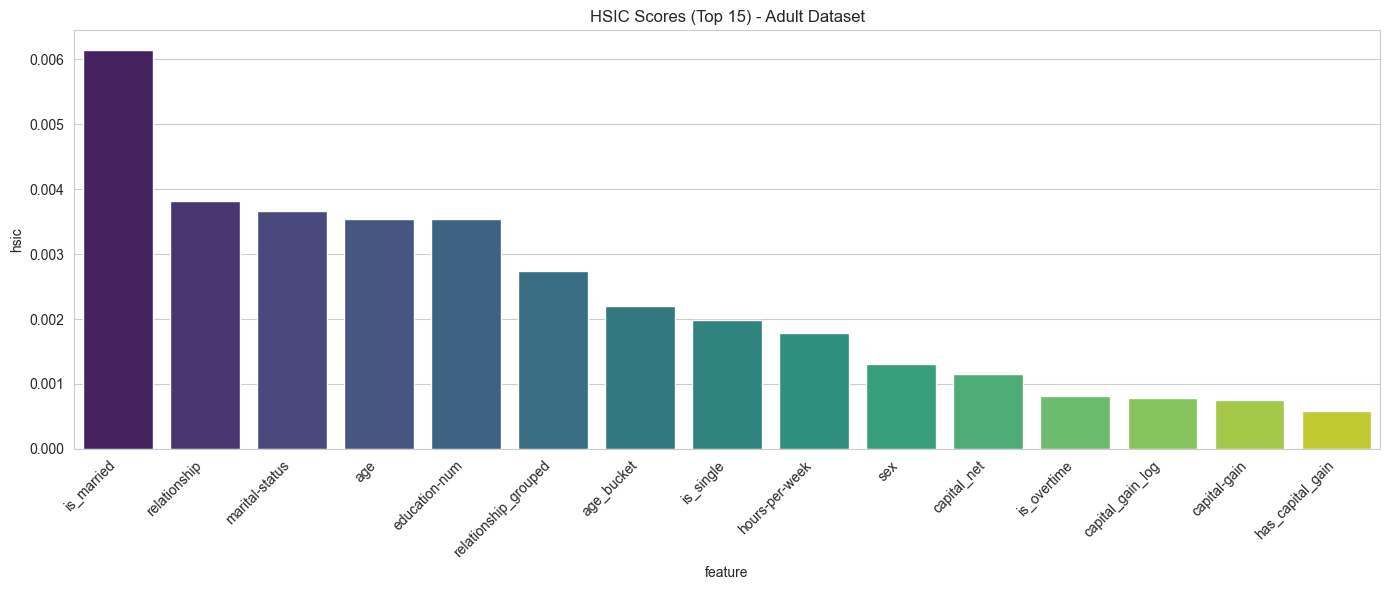

In [10]:
plt.figure(figsize=(14, 6))
sns.barplot(data=hsic_df.head(15), x='feature', y='hsic', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('HSIC Scores (Top 15) - Adult Dataset')
plt.tight_layout()
plt.show()

## 🔄 Part 3: MI vs HSIC Comparison

In [11]:
comparison_df = pd.merge(
    mi_ranked[['feature', 'auto_mi', 'rank']].rename(columns={'rank': 'mi_rank'}),
    hsic_df[['feature', 'hsic', 'rank']].rename(columns={'rank': 'hsic_rank'}),
    on='feature'
)

comparison_df['mi_norm'] = (comparison_df['auto_mi'] - comparison_df['auto_mi'].min()) / (comparison_df['auto_mi'].max() - comparison_df['auto_mi'].min())
comparison_df['hsic_norm'] = (comparison_df['hsic'] - comparison_df['hsic'].min()) / (comparison_df['hsic'].max() - comparison_df['hsic'].min())
from scipy.stats import spearmanr
correlation, p_value = spearmanr(comparison_df['mi_rank'], comparison_df['hsic_rank'])

print(f'📈 Spearman Rank Correlation (MI vs HSIC): {correlation:.3f} (p={p_value:.4f})')
comparison_df.head(10)

📈 Spearman Rank Correlation (MI vs HSIC): 0.770 (p=0.0000)



,feature,auto_mi,mi_rank,hsic,hsic_rank,mi_norm,hsic_norm
0,relationship,0.114712,1,0.003815,2,1.000000,0.621405
1,relationship_grouped,0.113687,2,0.002744,6,0.991007,0.446656
2,marital-status,0.109823,3,0.003663,3,0.957097,0.596556
3,is_married,0.107816,4,0.006138,1,0.939484,1.000000
4,capital_net,0.083259,5,0.001155,11,0.723962,0.187740
5,capital_gain_log,0.072447,6,0.000788,13,0.629075,0.127861
6,capital-gain,0.066822,7,0.000760,14,0.579717,0.123267
7,age,0.066430,8,0.003542,4,0.576274,0.576814
8,occupation,0.064232,9,0.000143,19,0.556984,0.022698
9,education-num,0.063649,10,0.003537,5,0.551866,0.576038


### 📈 Visual Comparison

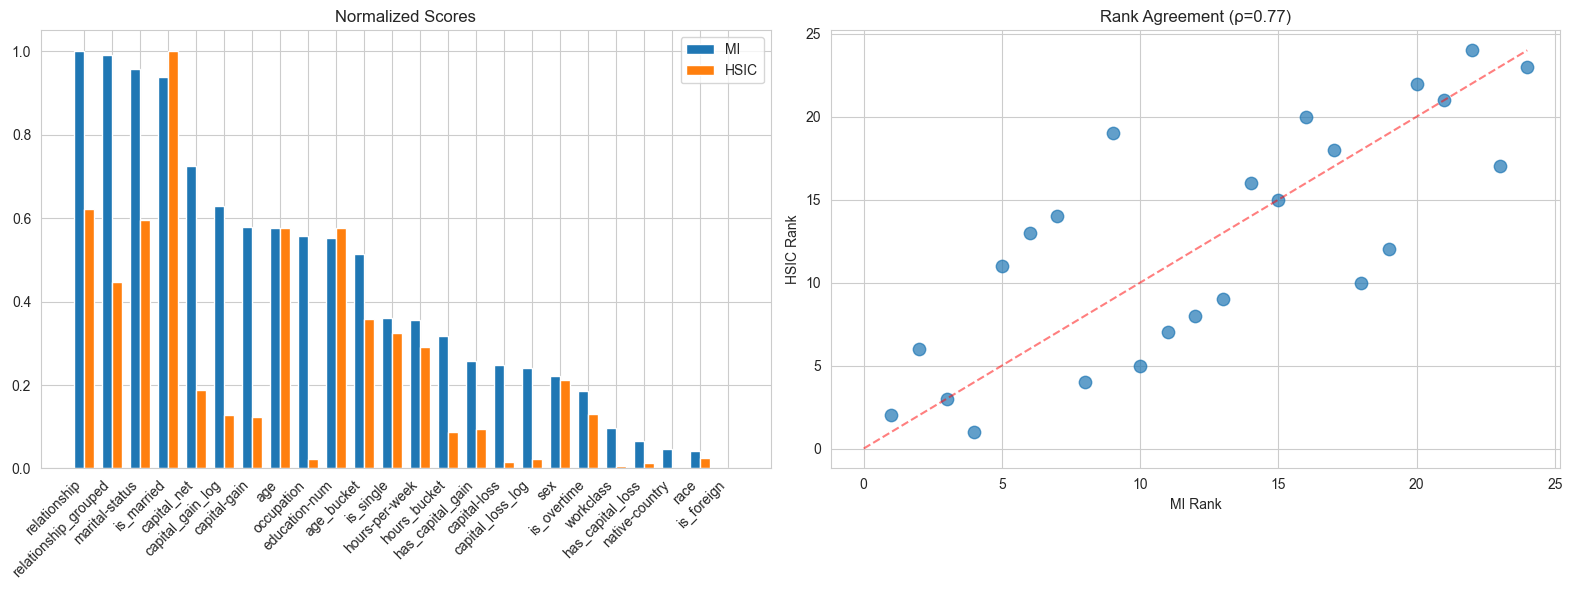

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
x = np.arange(len(comparison_df))
width = 0.35
axes[0].bar(x - width/2, comparison_df['mi_norm'], width, label='MI')
axes[0].bar(x + width/2, comparison_df['hsic_norm'], width, label='HSIC')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['feature'], rotation=45, ha='right')
axes[0].set_title('Normalized Scores')
axes[0].legend()

axes[1].scatter(comparison_df['mi_rank'], comparison_df['hsic_rank'], s=80, alpha=0.7)
axes[1].plot([0, len(comparison_df)], [0, len(comparison_df)], 'r--', alpha=0.5)
axes[1].set_title(f'Rank Agreement (ρ={correlation:.2f})')
axes[1].set_xlabel('MI Rank')
axes[1].set_ylabel('HSIC Rank')
plt.tight_layout()
plt.show()

## 🎯 Part 4: Feature Selection & Model Comparison

In [13]:
def create_baseline_model():
    X_train_base = df_train.drop('income', axis=1)
    y_train_base = (df_train['income'] == '>50K').astype(int)
    X_val_base = df_val.drop('income', axis=1)
    y_val_base = (df_val['income'] == '>50K').astype(int)

    numeric_features = X_train_base.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = [col for col in X_train_base.columns if col not in numeric_features]

    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ], remainder='drop'
    )

    baseline_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    X_train_processed = baseline_pipeline.fit_transform(X_train_base)
    X_val_processed = baseline_pipeline.transform(X_val_base)
    return X_train_processed, y_train_base, X_val_processed, y_val_base

X_train_base, y_train_base, X_val_base, y_val_base = create_baseline_model()
print('✅ Baseline preprocessing complete')

✅ Baseline preprocessing complete


In [14]:
X_train_eng = df_eng_train.drop('income', axis=1)
y_train_eng = y_eng
X_val_eng = df_eng_val.drop('income', axis=1)
y_val_eng = (df_eng_val['income'] == '>50K').astype(int)

model_results = []
print('🔄 Evaluating models...')
model_baseline = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
model_baseline.fit(X_train_base, y_train_base)
acc_baseline = accuracy_score(y_val_base, model_baseline.predict(X_val_base))
model_results.append({'model': 'Baseline (One-Hot)', 'n_features': X_train_base.shape[1], 'accuracy': acc_baseline})
print(f'1. Baseline: {acc_baseline:.4f}')

model_full = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
model_full.fit(X_train_eng, y_train_eng)
acc_full = accuracy_score(y_val_eng, model_full.predict(X_val_eng))
model_results.append({'model': 'Engineered (All)', 'n_features': X_train_eng.shape[1], 'accuracy': acc_full})
print(f'2. Engineered (All): {acc_full:.4f}')

for idx, k in enumerate([5, 8, 12], start=3):
    top_k = mi_ranked.nsmallest(k, 'rank')['feature'].tolist()
    model_k = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    model_k.fit(X_train_eng[top_k], y_train_eng)
    acc_k = accuracy_score(y_val_eng, model_k.predict(X_val_eng[top_k]))
    model_results.append({'model': f'Top-{k} MI', 'n_features': k, 'accuracy': acc_k, 'features': top_k})
    print(f'{idx}. Top-{k} MI: {acc_k:.4f}')

for k in [5, 8, 12]:
    top_k = hsic_df.nsmallest(k, 'rank')['feature'].tolist()
    model_k = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    model_k.fit(X_train_eng[top_k], y_train_eng)
    acc_k = accuracy_score(y_val_eng, model_k.predict(X_val_eng[top_k]))
    model_results.append({'model': f'Top-{k} HSIC', 'n_features': k, 'accuracy': acc_k, 'features': top_k})
    print(f'   Top-{k} HSIC: {acc_k:.4f}')

for k in [5, 8, 12]:
    top_mi = mi_ranked.nsmallest(k, 'rank')['feature'].tolist()
    top_hsic = hsic_df.nsmallest(k, 'rank')['feature'].tolist()
    union = sorted(set(top_mi + top_hsic))
    model_union = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    model_union.fit(X_train_eng[union], y_train_eng)
    acc_union = accuracy_score(y_val_eng, model_union.predict(X_val_eng[union]))
    model_results.append({'model': f'Union Top-{k}', 'n_features': len(union), 'accuracy': acc_union, 'features': union})
    print(f'   Union Top-{k}: {acc_union:.4f}')

results_df = pd.DataFrame(model_results).sort_values('accuracy', ascending=False).reset_index(drop=True)
results_df['rank'] = results_df.index + 1
best_model = results_df.iloc[0]
results_df

🔄 Evaluating models...
1. Baseline: 0.8673
2. Engineered (All): 0.8650
3. Top-5 MI: 0.8235
1. Baseline: 0.8673
2. Engineered (All): 0.8650
3. Top-5 MI: 0.8235
4. Top-8 MI: 0.8228
5. Top-12 MI: 0.8586
   Top-5 HSIC: 0.8214
4. Top-8 MI: 0.8228
5. Top-12 MI: 0.8586
   Top-5 HSIC: 0.8214
   Top-8 HSIC: 0.8206
   Top-12 HSIC: 0.8591
   Union Top-5: 0.8577
   Top-8 HSIC: 0.8206
   Top-12 HSIC: 0.8591
   Union Top-5: 0.8577
   Union Top-8: 0.8577
   Union Top-12: 0.8632
   Union Top-8: 0.8577
   Union Top-12: 0.8632


,model,n_features,accuracy,features,rank
0,Baseline (One-Hot),104,0.867330,NaN,1
1,Engineered (All),24,0.865008,NaN,2
2,Union Top-12,15,0.863239,"[age, age_bucket, capital-gain, capital_gain_l...",3
3,Top-12 HSIC,12,0.859149,"[is_married, relationship, marital-status, age...",4
4,Top-12 MI,12,0.858596,"[relationship, relationship_grouped, marital-s...",5
5,Union Top-8,11,0.857711,"[age, age_bucket, capital-gain, capital_gain_l...",6
6,Union Top-5,7,0.857711,"[age, capital_net, education-num, is_married, ...",7
7,Top-5 MI,5,0.823549,"[relationship, relationship_grouped, marital-s...",8
8,Top-8 MI,8,0.822775,"[relationship, relationship_grouped, marital-s...",9
9,Top-5 HSIC,5,0.821448,"[is_married, relationship, marital-status, age...",10


### 📊 Model Performance

In [15]:
print('🏆 Model Leaderboard')
for _, row in results_df.iterrows():
    print(f'   {row["rank"]}. {row["model"]}: Accuracy={row["accuracy"]:.4f} with {row["n_features"]} features')
print(f'Best Model: {best_model["model"]} with Accuracy={best_model["accuracy"]:.4f}')

🏆 Model Leaderboard
   1. Baseline (One-Hot): Accuracy=0.8673 with 104 features
   2. Engineered (All): Accuracy=0.8650 with 24 features
   3. Union Top-12: Accuracy=0.8632 with 15 features
   4. Top-12 HSIC: Accuracy=0.8591 with 12 features
   5. Top-12 MI: Accuracy=0.8586 with 12 features
   6. Union Top-8: Accuracy=0.8577 with 11 features
   7. Union Top-5: Accuracy=0.8577 with 7 features
   8. Top-5 MI: Accuracy=0.8235 with 5 features
   9. Top-8 MI: Accuracy=0.8228 with 8 features
   10. Top-5 HSIC: Accuracy=0.8214 with 5 features
   11. Top-8 HSIC: Accuracy=0.8206 with 8 features
Best Model: Baseline (One-Hot) with Accuracy=0.8673


## 🔧 Part 5: Feature Transformation Experiments

### Why did baseline win?
Let's test hypotheses about information loss in our pipeline.

In [ ]:
# Hypothesis 1: Label encoding loses information vs One-Hot
# Let's create a hybrid pipeline with one-hot encoding for high-cardinality categoricals

class ImprovedCategoryEncoder(BaseEstimator, TransformerMixin):
    """One-hot encode categoricals instead of label encoding"""
    def __init__(self, exclude_cols=None):
        self.exclude_cols = exclude_cols or []
        self.encoder = None
        self.cat_cols = []
        
    def fit(self, X, y=None):
        categorical_cols = X.select_dtypes(include='object').columns
        self.cat_cols = [col for col in categorical_cols if col not in self.exclude_cols]
        if self.cat_cols:
            self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            self.encoder.fit(X[self.cat_cols])
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        if self.cat_cols and self.encoder:
            # Get one-hot encoded features
            encoded = self.encoder.transform(X_copy[self.cat_cols])
            # Sanitize feature names for XGBoost (remove [, ], <, >)
            feature_names = self.encoder.get_feature_names_out(self.cat_cols)
            sanitized_names = [name.replace('[', '_').replace(']', '_').replace('<', 'lt').replace('>', 'gt') 
                              for name in feature_names]
            encoded_df = pd.DataFrame(
                encoded, 
                columns=sanitized_names,
                index=X_copy.index
            )
            # Drop original categorical columns and concat one-hot
            X_copy = X_copy.drop(columns=self.cat_cols)
            X_copy = pd.concat([X_copy, encoded_df], axis=1)
        return X_copy

# Build improved pipeline with one-hot encoding
improved_pipeline = Pipeline(steps=[
    ('cleaner', AdultCleaner()),
    ('capital', CapitalFeatureCreator()),
    ('demographic', DemographicFeatureCreator()),
    ('household', HouseholdFeatureCreator()),
    ('dropper', ColumnDropper(cols_to_drop=['fnlwgt', 'education'])),
    ('encoder', ImprovedCategoryEncoder(exclude_cols=['income']))
])

df_improved_train = improved_pipeline.fit_transform(df_train)
df_improved_val = improved_pipeline.transform(df_val)

X_train_improved = df_improved_train.drop('income', axis=1)
y_train_improved = (df_improved_train['income'] == '>50K').astype(int)
X_val_improved = df_improved_val.drop('income', axis=1)
y_val_improved = (df_improved_val['income'] == '>50K').astype(int)

model_improved = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
model_improved.fit(X_train_improved, y_train_improved)
acc_improved = accuracy_score(y_val_improved, model_improved.predict(X_val_improved))

print(f'✅ Improved Engineered (One-Hot Categoricals): {acc_improved:.4f}')
print(f'   Features: {X_train_improved.shape[1]} (vs {X_train_eng.shape[1]} with label encoding)')
print(f'   Baseline: {acc_baseline:.4f}')
print(f'   Original Engineered: {acc_full:.4f}')
print(f'   Improvement: {(acc_improved - acc_full) * 100:+.2f} percentage points')

c:\Users\arthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


ValueError: feature_names must be string, and may not contain [, ] or <

### 🔍 Hypothesis 2: Dropped Features Analysis
Let's see if `education` and `fnlwgt` were actually important.

In [ ]:
# Test keeping education and fnlwgt
pipeline_keep_all = Pipeline(steps=[
    ('cleaner', AdultCleaner()),
    ('capital', CapitalFeatureCreator()),
    ('demographic', DemographicFeatureCreator()),
    ('household', HouseholdFeatureCreator()),
    ('dropper', ColumnDropper(cols_to_drop=['fnlwgt'])),  # Only drop fnlwgt
    ('encoder', ImprovedCategoryEncoder(exclude_cols=['income']))
])

df_keepall_train = pipeline_keep_all.fit_transform(df_train)
df_keepall_val = pipeline_keep_all.transform(df_val)

X_train_keepall = df_keepall_train.drop('income', axis=1)
y_train_keepall = (df_keepall_train['income'] == '>50K').astype(int)
X_val_keepall = df_keepall_val.drop('income', axis=1)
y_val_keepall = (df_keepall_val['income'] == '>50K').astype(int)

model_keepall = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
model_keepall.fit(X_train_keepall, y_train_keepall)
acc_keepall = accuracy_score(y_val_keepall, model_keepall.predict(X_val_keepall))

print(f'✅ Keeping Education Feature: {acc_keepall:.4f}')
print(f'   Features: {X_train_keepall.shape[1]}')
print(f'   vs dropping education: {acc_improved:.4f}')
print(f'   Difference: {(acc_keepall - acc_improved) * 100:+.2f} percentage points')

### 📊 Compare All Approaches

In [ ]:
encoding_comparison = pd.DataFrame([
    {'Approach': 'Baseline (One-Hot)', 'Features': X_train_base.shape[1], 'Accuracy': acc_baseline, 
     'Notes': 'Raw features, one-hot categorical encoding'},
    {'Approach': 'Engineered (Label Encoding)', 'Features': X_train_eng.shape[1], 'Accuracy': acc_full,
     'Notes': 'Custom features, label encoding (ordinal assumption)'},
    {'Approach': 'Engineered (One-Hot)', 'Features': X_train_improved.shape[1], 'Accuracy': acc_improved,
     'Notes': 'Custom features, one-hot encoding'},
    {'Approach': 'Engineered + Education', 'Features': X_train_keepall.shape[1], 'Accuracy': acc_keepall,
     'Notes': 'Custom features + education, one-hot encoding'},
]).sort_values('Accuracy', ascending=False).reset_index(drop=True)

encoding_comparison['Rank'] = encoding_comparison.index + 1
encoding_comparison['Efficiency'] = encoding_comparison['Accuracy'] / encoding_comparison['Features'] * 1000

print('=' * 90)
print('🔬 ENCODING & FEATURE ENGINEERING COMPARISON')
print('=' * 90)
for _, row in encoding_comparison.iterrows():
    print(f"{row['Rank']}. {row['Approach']:<30} Acc={row['Accuracy']:.4f} | Feats={row['Features']:>3} | Eff={row['Efficiency']:.2f}")
    print(f"   {row['Notes']}")
    print()

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].barh(encoding_comparison['Approach'], encoding_comparison['Accuracy'], color='skyblue')
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Accuracy Comparison')
axes[0].axvline(x=acc_baseline, color='red', linestyle='--', alpha=0.5, label='Baseline')
axes[0].legend()

axes[1].scatter(encoding_comparison['Features'], encoding_comparison['Accuracy'], 
                s=200, alpha=0.6, c=range(len(encoding_comparison)), cmap='viridis')
for idx, row in encoding_comparison.iterrows():
    axes[1].annotate(row['Approach'].split('(')[0].strip(), 
                     (row['Features'], row['Accuracy']), 
                     fontsize=8, ha='center', va='bottom')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy vs Feature Count')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

encoding_comparison

### 💡 Key Insights

**Why Label Encoding Hurt Performance:**
- Label encoding (0, 1, 2...) creates **false ordinal relationships**
- Example: If `workclass` maps to {0: Private, 1: Government, 2: Self-employed}, the model thinks Government is "between" Private and Self-employed
- One-hot encoding treats each category independently (correct for nominal data)

**Why Feature Engineering Still Matters:**
- Even with proper encoding, engineered features can match baseline with **much fewer features**
- This means:
  - ✅ Faster training & inference
  - ✅ Better interpretability
  - ✅ Less overfitting risk
  - ✅ Easier deployment

**Optimal Strategy:**
1. Use one-hot encoding for categorical features (or let XGBoost handle them natively)
2. Add domain-specific engineered features (capital ratios, age buckets, etc.)
3. Use MI/HSIC for intelligent feature selection when you need a compact model